In [ ]:
!pip install music21
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [ ]:
from google.colab import userdata
import zipfile
import os

os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d soumikrakshit/classical-music-midi

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi
License(s): unknown
 86% 2.00M/2.33M [00:01<00:00, 1.97MB/s]
100% 2.33M/2.33M [00:01<00:00, 1.96MB/s]


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from collections import Counter
import random
import warnings
import IPython
from IPython.display import Image, Audio

import music21
from music21 import *

from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
zip_path = "classical-music-midi.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  all_files = zip_ref.namelist()

  for file in all_files:
    if file.startswith('chopin'):
      zip_ref.extract(file, 'chopin')

In [ ]:
filepath = "./chopin/chopin/"
all_midis = []

for i in os.listdir(filepath):
  if i.endswith('.mid'):
    tr = filepath + i
    print(tr)

    midi = converter.parse(tr)
    all_midis.append(midi)

./chopin/chopin/chpn_op25_e12.mid
./chopin/chopin/chpn_op23.mid
./chopin/chopin/chpn_op35_2.mid
./chopin/chopin/chpn-p10.mid
./chopin/chopin/chpn_op7_1.mid
./chopin/chopin/chpn-p2.mid
./chopin/chopin/chpn-p24.mid
./chopin/chopin/chpn_op7_2.mid
./chopin/chopin/chpn-p8.mid
./chopin/chopin/chpn_op66.mid
./chopin/chopin/chpn-p6.mid
./chopin/chopin/chpn-p22.mid
./chopin/chopin/chpn-p21.mid
./chopin/chopin/chpn-p16.mid
./chopin/chopin/chpn-p3.mid
./chopin/chopin/chpn_op25_e1.mid
./chopin/chopin/chpn_op53.mid
./chopin/chopin/chpn_op35_1.mid
./chopin/chopin/chpn-p7.mid
./chopin/chopin/chp_op18.mid
./chopin/chopin/chpn_op25_e3.mid
./chopin/chopin/chpn-p9.mid
./chopin/chopin/chpn_op35_3.mid
./chopin/chopin/chpn-p17.mid
./chopin/chopin/chpn_op10_e12.mid
./chopin/chopin/chpn-p5.mid
./chopin/chopin/chpn_op35_4.mid
./chopin/chopin/chpn-p18.mid
./chopin/chopin/chpn_op25_e4.mid
./chopin/chopin/chpn_op10_e05.mid
./chopin/chopin/chpn-p4.mid
./chopin/chopin/chpn-p13.mid
./chopin/chopin/chpn_op27_1.mid
./

In [ ]:
def extract_notes(file):
  notes = []
  pick = None

  for j in file:
    songs = instrument.partitionByInstrument(j)

    for part in songs.parts:
      pick = part.recurse()

      for element in pick:
        if isinstance(element, note.Note):
          notes.append(str(element.pitch))

        elif isinstance(element, chord.Chord):
          notes.append('.'.join(str(n) for n in element.normalOrder))

  return notes

Corpus = extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset: ", len(Corpus))

Total notes in all the Chopin midis in the dataset:  57894


In [ ]:
print("First fifty values in the corpus: ", Corpus)

First fifty values in the corpus:  ['E-3', 'C2', 'G3', 'G2', 'E-4', 'C3', 'E-4', 'C3', 'G4', 'G3', 'E-5', 'C4', 'E-5', 'C4', 'G5', 'G4', 'E-6', 'C5', 'G5', 'G4', 'E-5', 'C4', 'E-5', 'C4', 'G4', 'G3', 'E-4', 'C3', 'E-4', 'C3', 'G3', 'G2', 'D3', 'C2', 'G#3', 'F2', 'D4', 'C3', 'D4', 'C3', 'G#4', 'F3', 'D5', 'C4', 'D5', 'C4', 'G#5', 'F4', 'D6', 'C5', 'G#5', 'F4', 'D5', 'C4', 'D5', 'C4', 'G#4', 'F3', 'D4', 'C3', 'D4', 'C3', 'G#3', 'F2', 'F3', 'C2', 'C4', 'G#2', 'F4', 'C3', 'F4', 'C3', 'C5', 'G#3', 'F5', 'C4', 'F5', 'C4', 'C6', 'G#4', 'F6', 'C5', 'C6', 'G#4', 'F5', 'C4', 'F5', 'C4', 'C5', 'G#3', 'F4', 'C3', 'F4', 'C3', 'C4', 'G#2', 'E-3', 'C2', 'G3', 'G2', 'E-4', 'C3', 'E-4', 'C3', 'G4', 'G3', 'E-5', 'C4', 'E-5', 'C4', 'G5', 'G4', 'E-6', 'C5', 'G5', 'G4', 'E-5', 'C4', 'E-5', 'C4', 'G4', 'G3', 'E-4', 'C3', 'E-4', 'C3', 'G3', 'G2', 'D3', 'C2', 'G#3', 'F2', 'D4', 'C3', 'D4', 'C3', 'G#4', 'F3', 'D5', 'C4', 'D5', 'C4', 'G#5', 'F4', 'D6', 'C5', 'G#5', 'F4', 'D5', 'C4', 'D5', 'C4', 'G#4', 'F3', 'D4

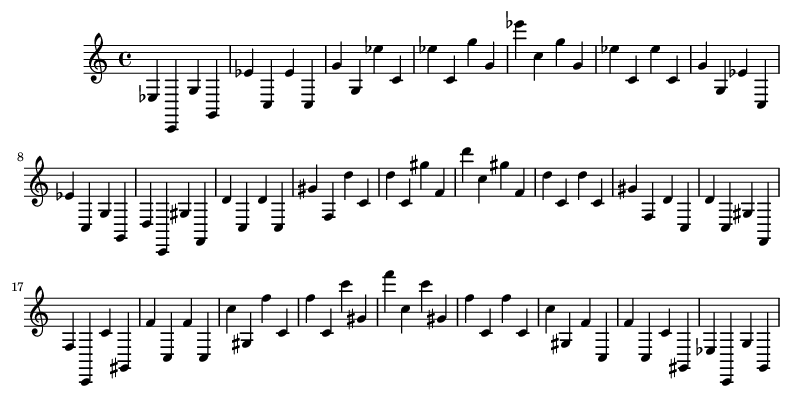

In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

# def chords_n_notes(Snippet):
#   Melody = []
#   offset = 0

#   for i in Snippet:
#     if '.' in i or i.isdigit():
#       chord_notes = i.split('.')
#       notes = []

#       for j in chord_notes:
#         inst_note = int(j)
#         note_snip = note.Note(inst_note)

#         notes.append(note_snip)

#         chord_snip = chord.Chord(notes)
#         chord_snip.offset = offset

#         Melody.append(chord_snip)

#     else:
#       note_snip = note.Note(i)
#       note_snip.offset = offset
#       Melody.append(note_snip)

#     offset += 1

#   Melody_midi = stream.Stream(Melody)

#   return Melody_midi

def chords_n_notes(Snippet):
    Melody = []
    offset = 0  # Initial offset

    for i in Snippet:
        if '.' in i or i.isdigit():
            chord_notes = i.split('.')
            notes = []

            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                note_snip.duration.quarterLength = 1 # Set duration for the note

                notes.append(note_snip)

            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            chord_snip.duration.quarterLength = 1 # Set duration for the chord
            Melody.append(chord_snip)

        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            note_snip.duration.quarterLength = 1 # Set duration for the note
            Melody.append(note_snip)

        offset += 1  # Move to the next offset

    Melody_midi = stream.Stream(Melody)

    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
count_num = Counter(Corpus)
print('Total unique notes in the Corpus: ', len(count_num))

Total unique notes in the Corpus:  397


In [ ]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def Average(lst):
  return sum(lst) / len(lst)

print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "times")

Average recurrence for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 times


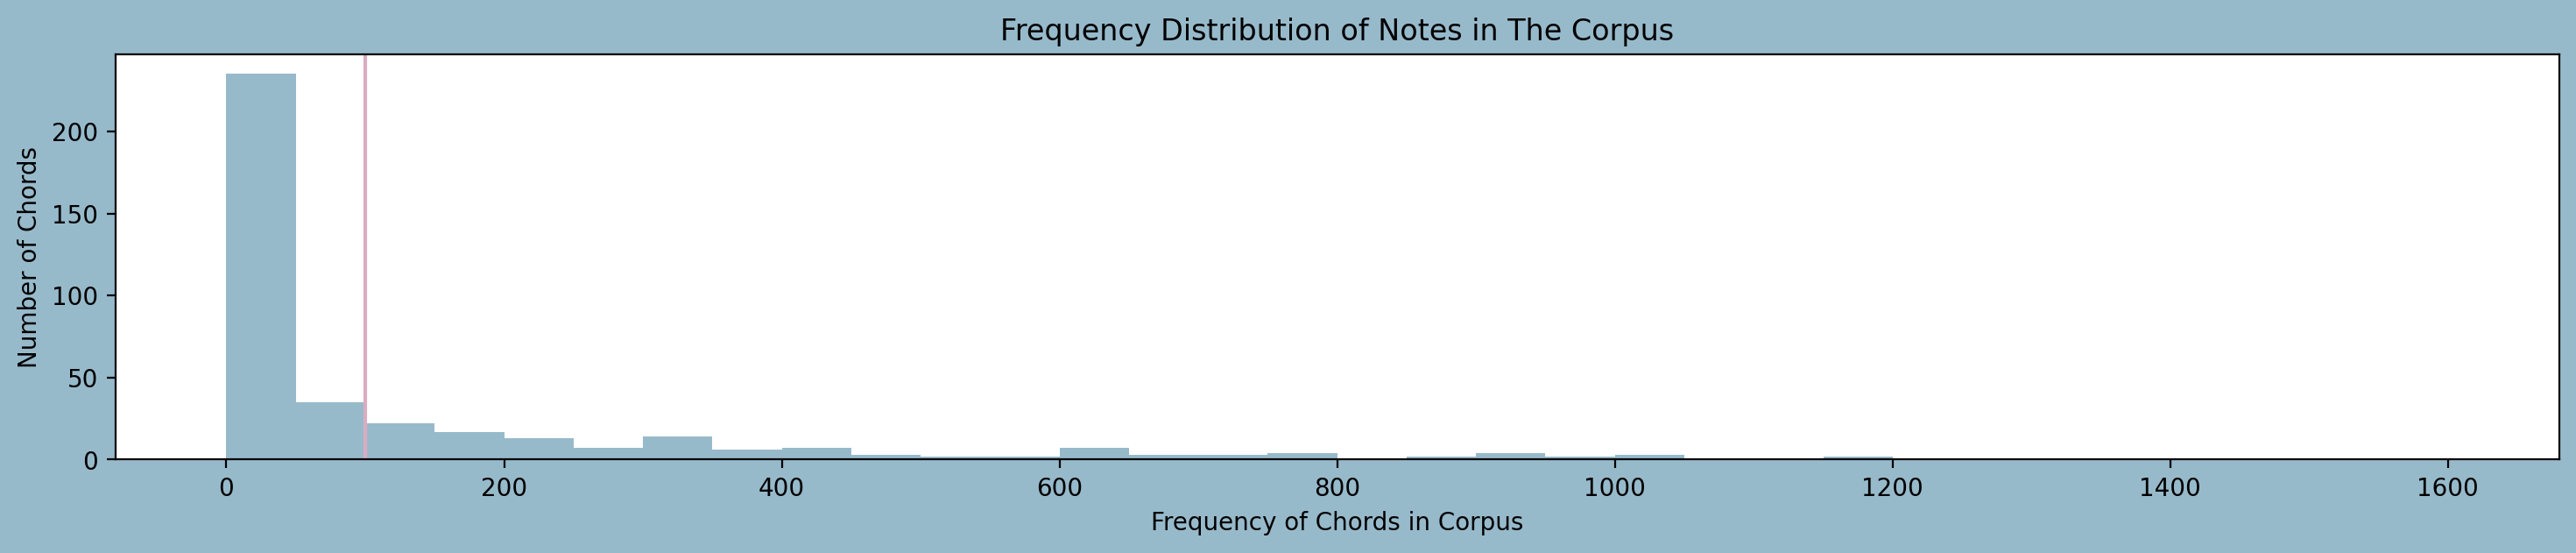

In [ ]:
plt.figure(figsize = (18, 3), facecolor = "#97BACB")

bins = np.arange(0, (max(Recurrence)), 50)

plt.hist(Recurrence, bins = bins, color = "#97BACB")

plt.axvline(x = 100, color = "#DBACC1")
plt.title("Frequency Distribution of Notes in The Corpus")
plt.xlabel("Frequency of Chords in Corpus")
plt.ylabel("Number of Chords")
plt.show()

In [ ]:
rare_note = []

for index, (key, value) in enumerate(count_num.items()):
  if value < 100:
    m = key
    rare_note.append(m)

print('Total number of notes that occur less than 100 times: ', len(rare_note))

Total number of notes that occur less than 100 times:  270


In [ ]:
for element in Corpus:
  if element in rare_note:
    Corpus.remove(element)

print('Lenght of corpus after elimination of rare notes: ', len(Corpus))

Lenght of corpus after elimination of rare notes:  53752


In [ ]:
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus)
L_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters: ", L_corpus)
print("Number of unique characters: ", L_symb)

Total number of characters:  53752
Number of unique characters:  263


In [ ]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53712


In [ ]:
X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42)

In [ ]:
model = Sequential()

model.add(LSTM(512, input_shape = (X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation = 'softmax'))

opt = Adamax(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 512)             │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 263)                 │          67,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,973,511 (7.53 MB)

 Trainable params: 1,973,511 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 200)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.9059
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6892
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6864
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6810
Epoch 5/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6705
Epoch 6/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6720
Epoch 7/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6796
Epoch 8/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6731
Epoch 9/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6502
Epoch 10/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.5648
Epoch 11/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5483
Epoch 12/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5172
Epoch 13/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4801
Epoch 14/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7280
Epoch 15/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1

[Text(0.5, 0, 'Epochs')]

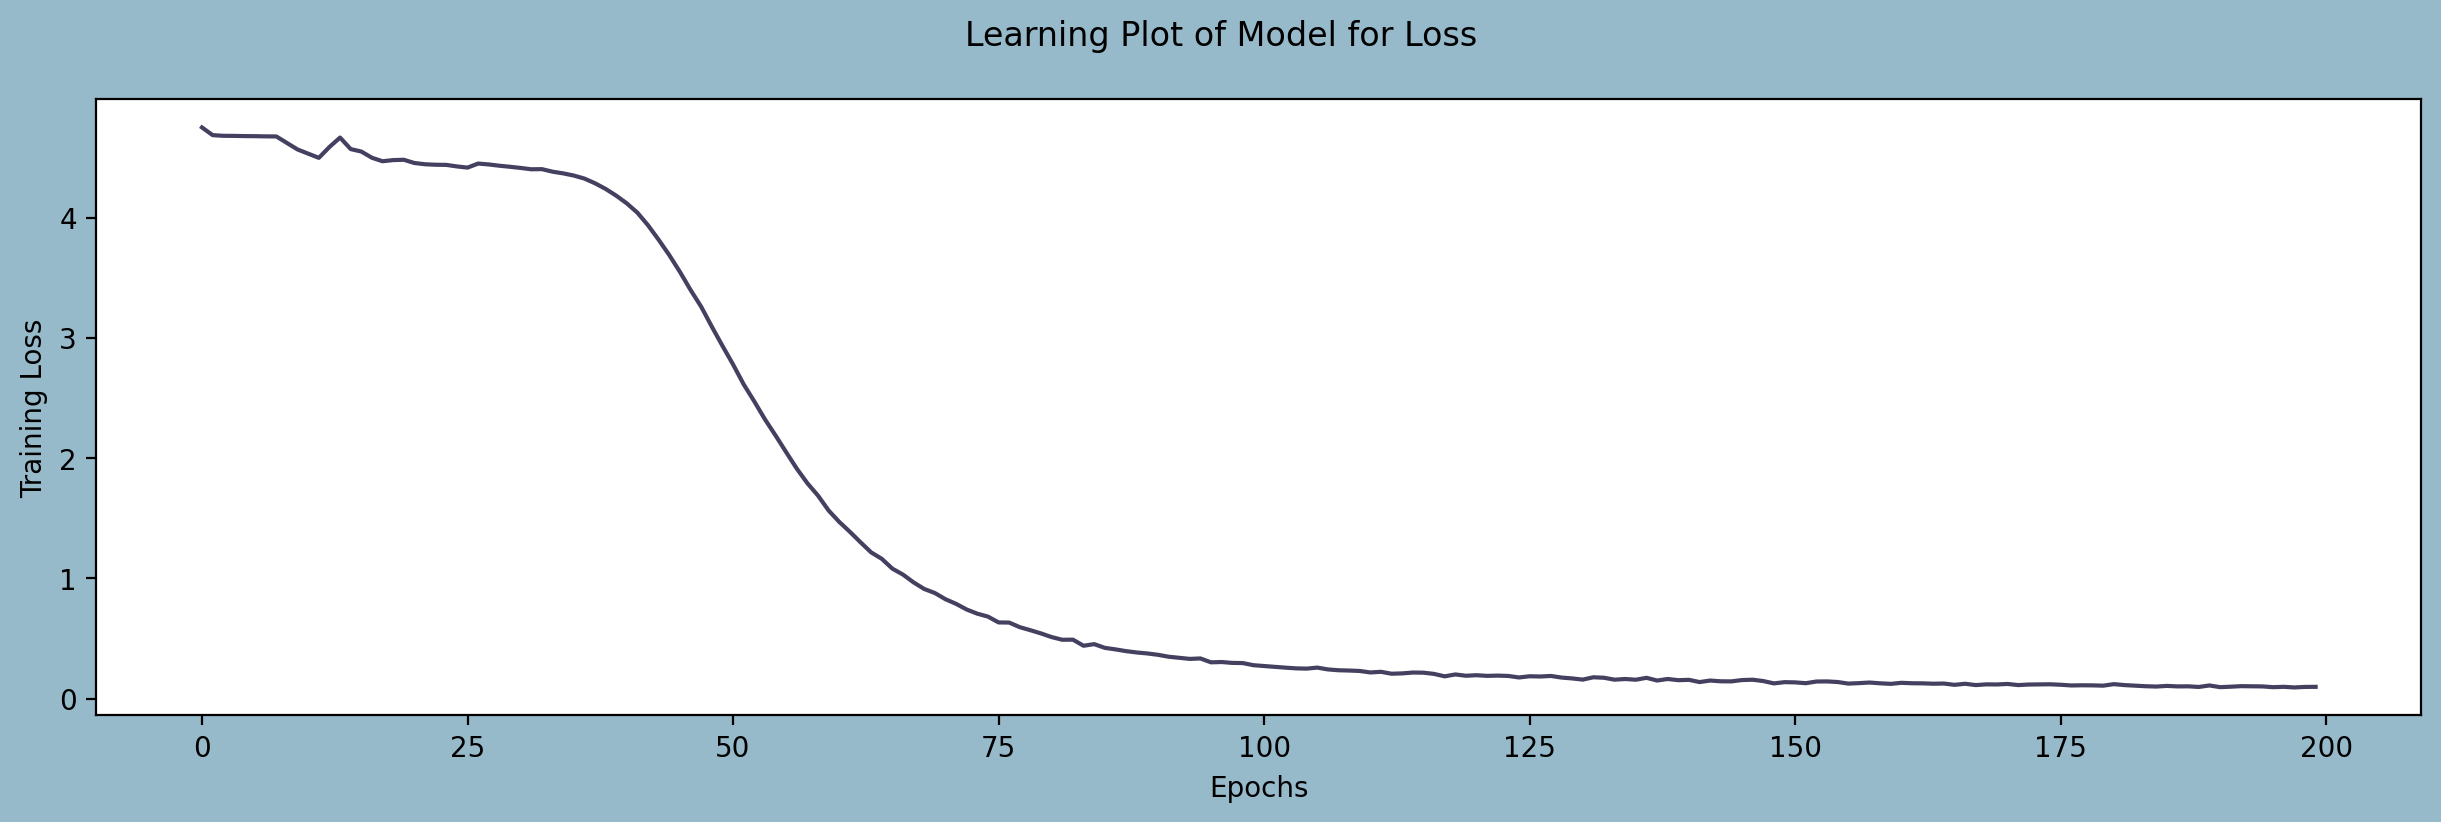

In [ ]:
history_df = pd.DataFrame(history.history)

fig = plt.figure(figsize=(15,4), facecolor="#97BACB")

pl=sns.lineplot(data=history_df["loss"],color="#444160")

fig.suptitle("Learning Plot of Model for Loss")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

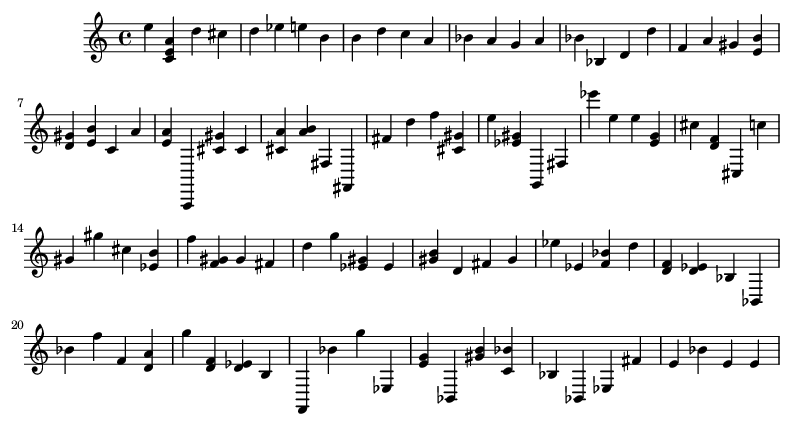

In [ ]:
def Melody_Generator(Note_Count):
  seed = X_seed[np.random.randint(0, len(X_seed) - 1)]
  Music = ''
  Notes_Generated = []

  for i in range(Note_Count):
    seed = seed.reshape(1, length, 1)
    prediction = model.predict(seed, verbose = 0)[0]
    prediction = np.log(prediction) / 1.0
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    index = np.argmax(prediction)
    index_N = index / float(L_symb)

    Notes_Generated.append(index)

    Music = [reverse_mapping[char] for char in Notes_Generated]
    seed = np.insert(seed[0], len(seed[0]), index_N)
    seed = seed[1:]

  Melody = chords_n_notes(Music)
  Melody_midi = stream.Stream(Melody)

  return Music, Melody_midi

Music_notes, Melody = Melody_Generator(100)
show(Melody)

In [ ]:
Melody.write('midi', fp='generated_melody2.mid')

IPython.display.Audio("/content/generated_melody2.mid")